# 💀 Bone Fracture Multi-Region X-ray

이 데이터셋은 하지, 상지, 요추, 엉덩이, 무릎 등 모든 해부학적 신체 부위를 포함하는 골절 및 비골절 X-레이 이미지를 포함하고 있습니다. 

데이터 출처 : https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data


In [10]:
# import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from IPython.display import display


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn #모델 정의
import torch.nn.functional as F #모델 정의
from torch.utils.data import TensorDataset, DataLoader #데이터로드
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim # 옵티마이저
from sklearn.metrics import precision_score, recall_score, f1_score

## 데이터 사전 정리

In [3]:
# 파일명 정리
def chage_name(folder_path, name_code, start_numder = 1):
    name_list = [file for file in os.listdir(folder_path) if file.endswith((".png",".jpg",".jpeg"))]
    digit = len(str(len(name_list))) + 1
    for idex, file in enumerate(name_list):
        numder = digit - len(str(idex))
        position = file.rfind(".")
        following_text = file[position:]

        old_file_path = os.path.join(folder_path, file)
        new_file_name = name_code + "0" * numder + str(idex + start_numder) + following_text
        new_file_path = os.path.join(folder_path, new_file_name)
        os.rename(old_file_path, new_file_path)

    updated_files = os.listdir(folder_path)
    print(updated_files)

In [4]:
# 파일 확정자 변경
def change_file_determiner(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".png") or filename.endswith(".bmp"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            # 팔레트 모드(P)에서 RGB로 변환
            if img.mode == 'P':
                img = img.convert('RGB')
            # RGBA를 RGB로 변환, 필요한 경우
            elif img.mode == 'RGBA':
                img = img.convert('RGB')
            new_filename = filename.split('.')[0] + '.jpeg'
            new_img_path = os.path.join(directory, new_filename)
            img.save(new_img_path, 'JPEG')
            os.remove(img_path)  # 원본 파일 삭제

In [5]:
# F_name = "BXF_TR_"
# image_path_fractured = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/fractured"

# N_name = "BXN_TR_"
# image_path_No = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/not fractured"

# change_file_determiner(image_path_fractured)
# chage_name(image_path_fractured,F_name,0)
# change_file_determiner(image_path_No)
# chage_name(image_path_No,N_name,0)


# F_name = "BXF_VA_"
# image_path_fractured = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/fractured"

# N_name = "BXN_VA_"
# image_path_No = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/not fractured"

# change_file_determiner(image_path_fractured)
# chage_name(image_path_fractured,F_name,0)
# change_file_determiner(image_path_No)
# chage_name(image_path_No,N_name,0)

# F_name = "BXF_TE_"
# image_path_fractured = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/fractured"

# N_name = "BXN_TE_"
# image_path_No = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/not fractured"

# change_file_determiner(image_path_fractured)
# chage_name(image_path_fractured,F_name,0)
# change_file_determiner(image_path_No)
# chage_name(image_path_No,N_name,0)

In [6]:
data_dir = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data"
data = os.listdir(data_dir)
len(data)

3

In [7]:
def data_image_len(dir):
    data = os.listdir(dir)
    return len(data)

In [8]:
BB_test_fr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/fractured"
BB_test_nfr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/not fractured"
BB_train_fr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/fractured"
BB_train_nfr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/not fractured"
BB_val_fr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/fractured"
BB_val_nfr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/not fractured"

data_dir_list = [BB_test_fr,BB_test_nfr,BB_train_fr,BB_train_nfr,BB_val_fr,BB_val_nfr]

for i in data_dir_list:
    print(data_image_len(i))

238
268
4604
4640
337
492


In [11]:
def show_random_images(image_path):
    # 이미지 파일 확장자 리스트
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    
    # 주어진 경로에서 모든 파일을 리스트업
    all_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
    
    # 이미지 파일만 필터링
    image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in valid_extensions]
    
    # 이미지 파일이 9개 미만일 경우 모든 이미지를 보여줌
    if len(image_files) < 9:
        selected_images = image_files
    else:
        # 무작위로 9개의 이미지 파일 선택
        selected_images = random.sample(image_files, 9)
    
    # 선택된 이미지 파일을 출력
    for image_file in selected_images:
        image = Image.open(image_file)
        display(image)

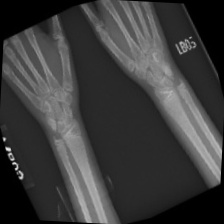

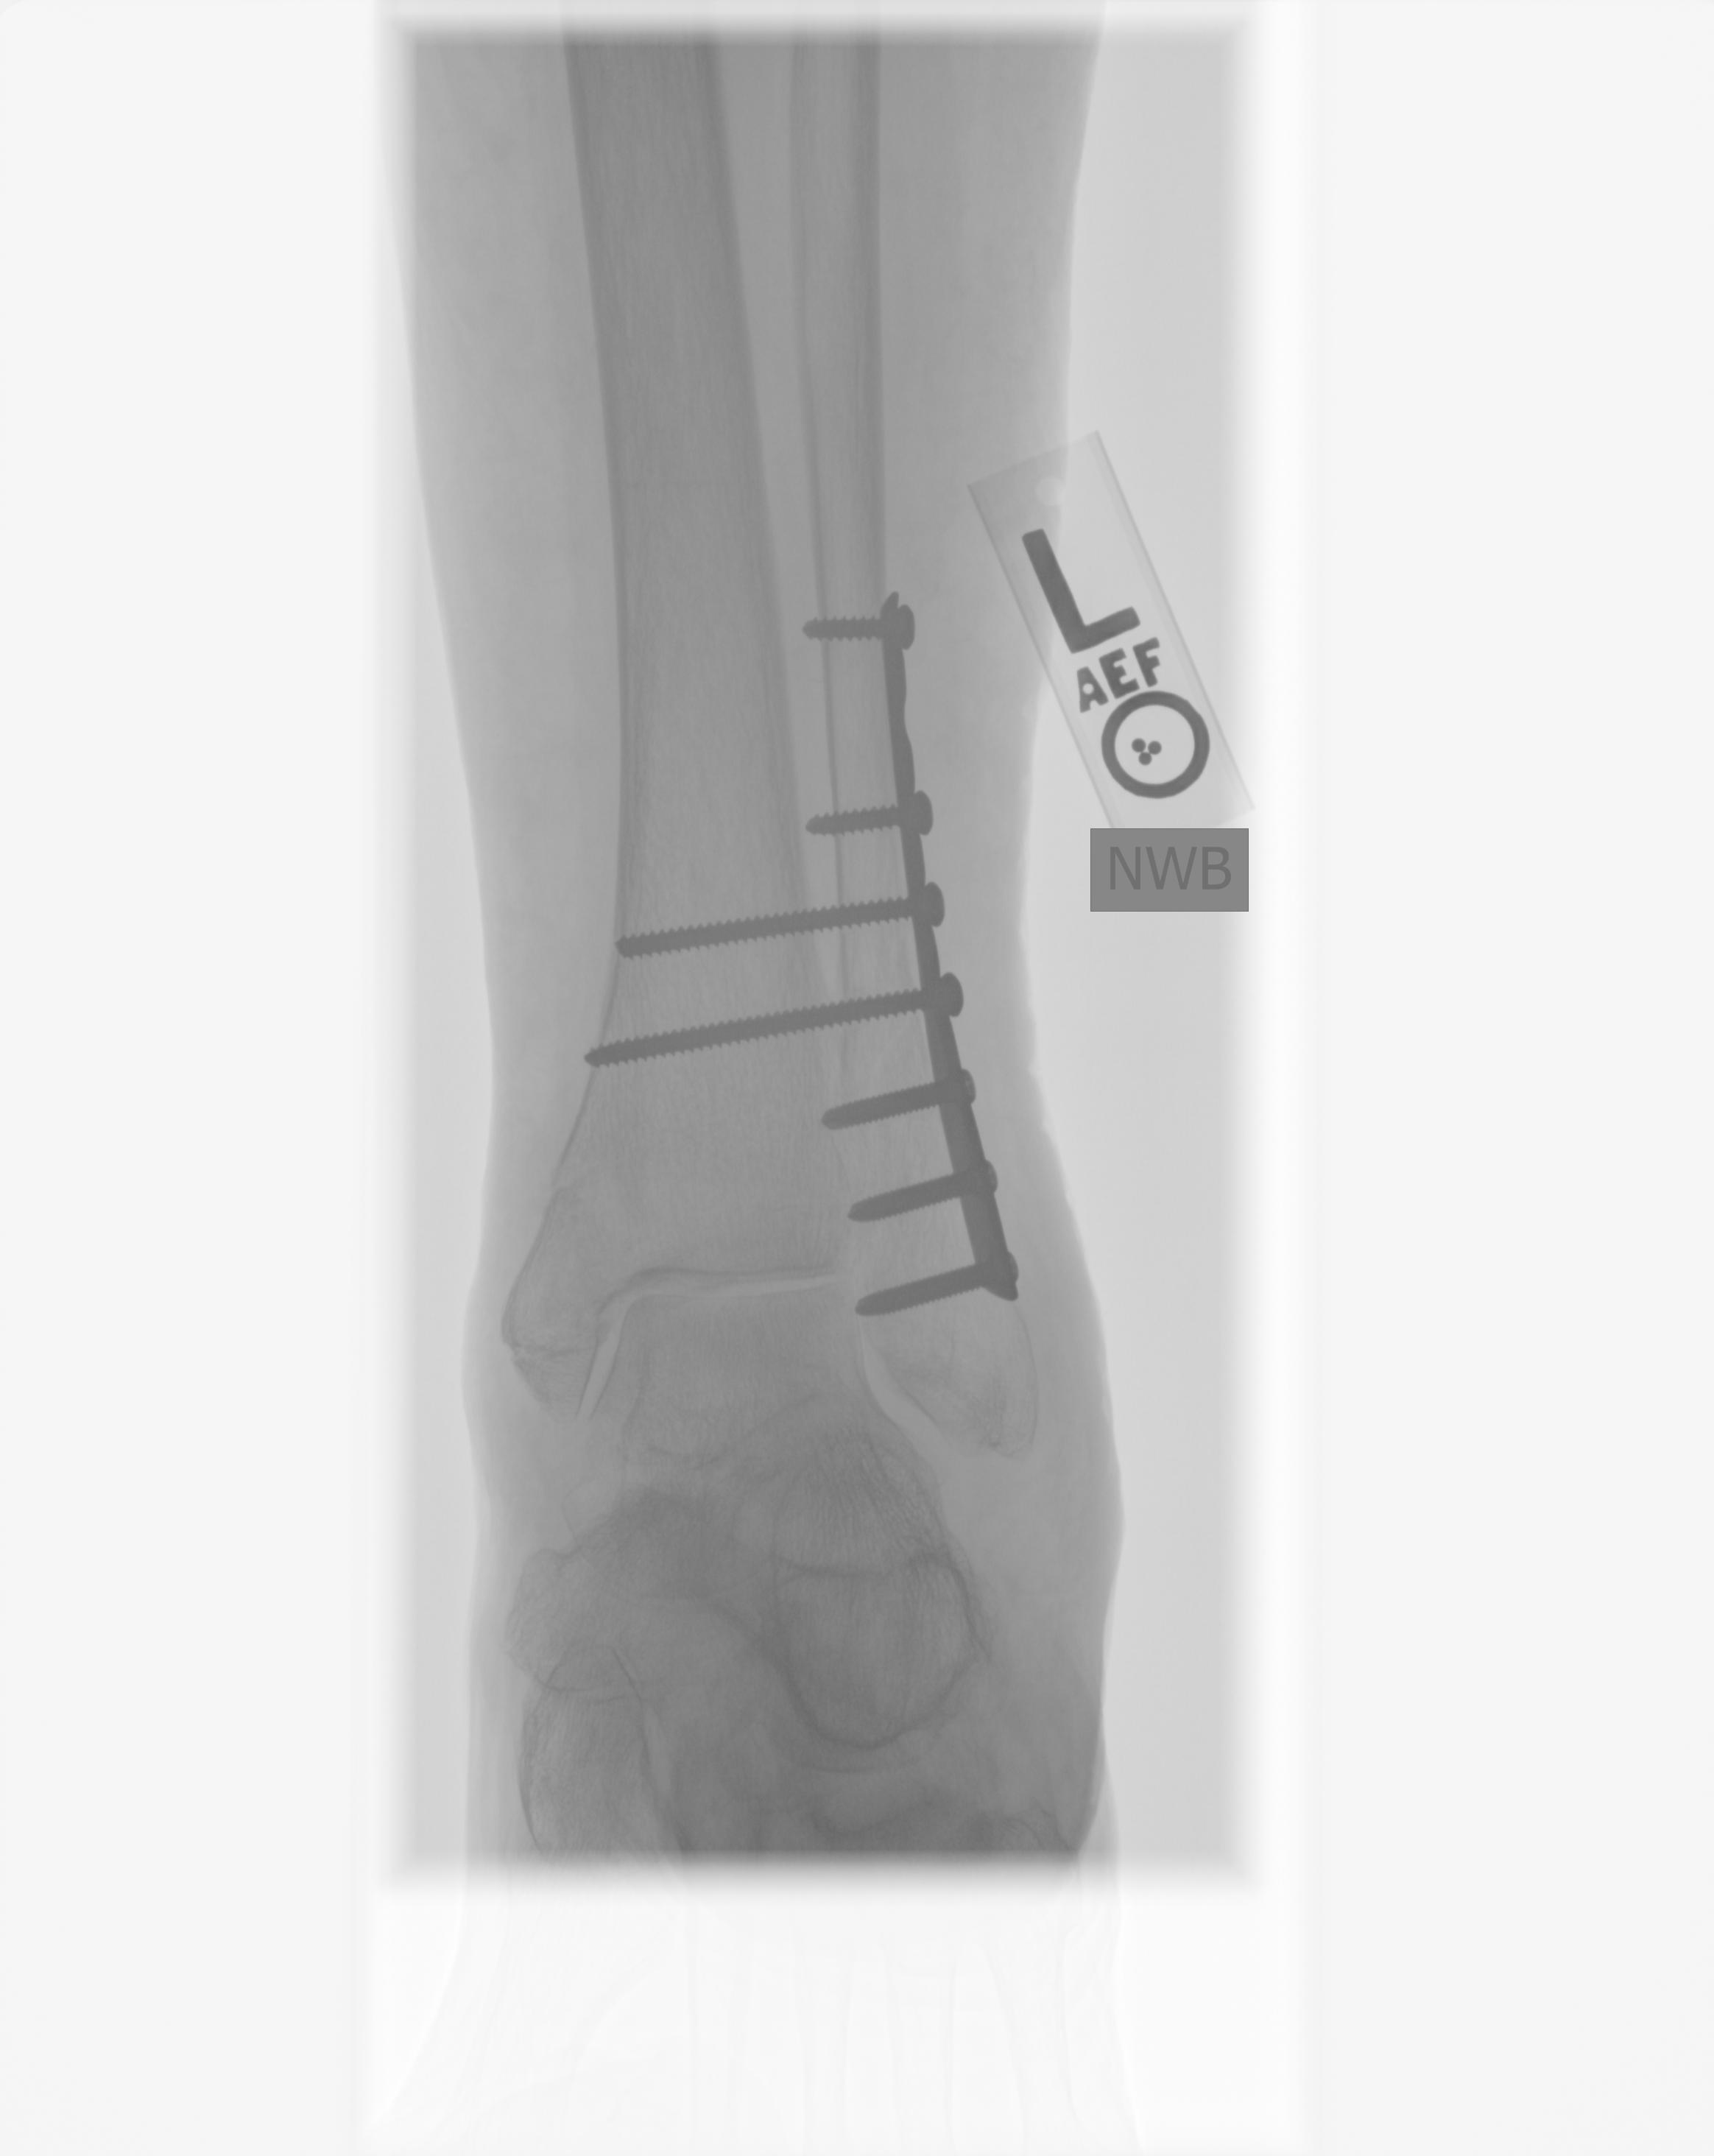

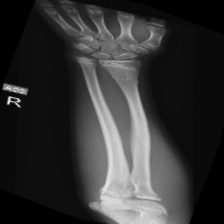

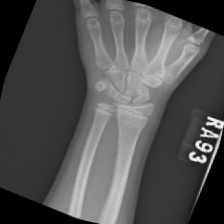

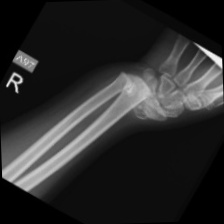

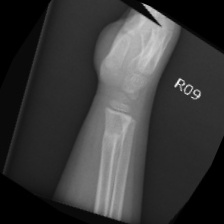

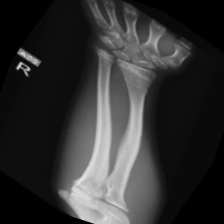

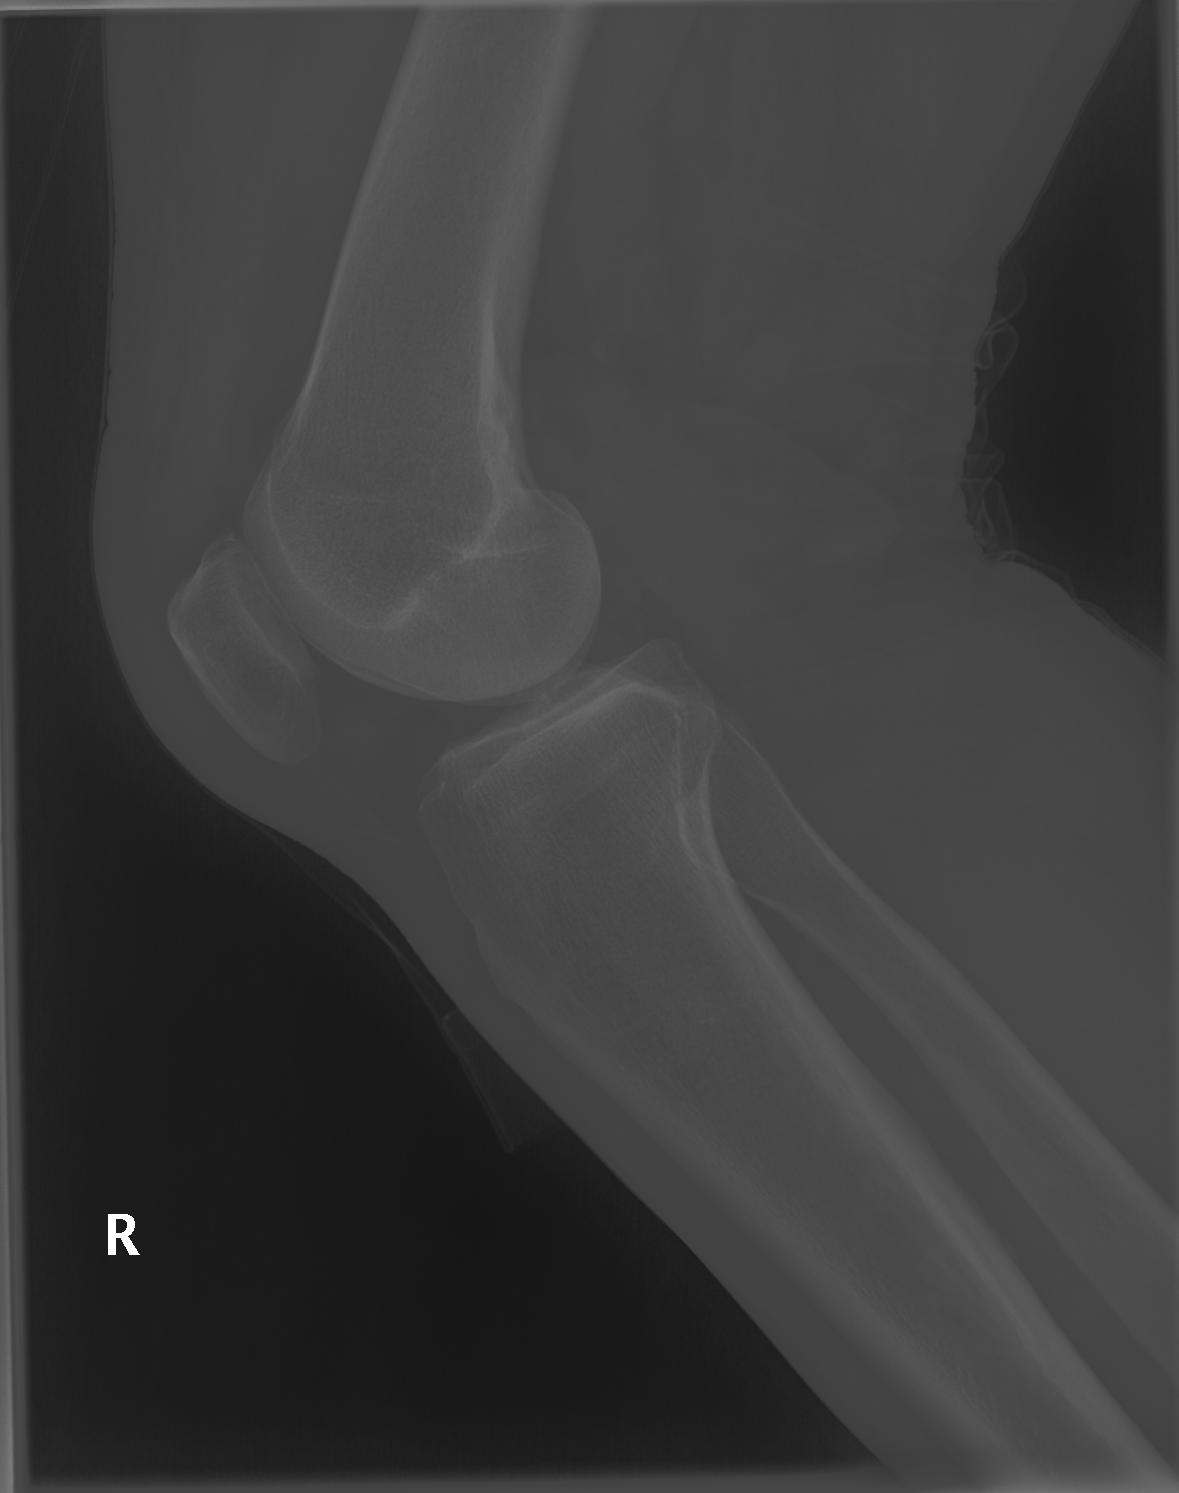

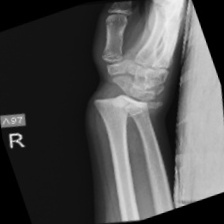

In [13]:
show_random_images(BB_test_fr)